<a href="https://www.kaggle.com/code/aneevinay/ps5e10-accident-risk?scriptVersionId=271534785" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# ** PREDICTING ROAD ACCIDENTS RISK - REGRESSION PROBLEM **

# Introduction

> This data science project is a part of https://www.kaggle.com/competitions/playground-series-s5e10 .It aims to predict road accident risk by applying machine learning methods. The objective is to predict risk level of road by analyzing their factors. The project involves preprocessing ,categorical encoding the train and test data , and apply regression machine learning model xgb regressor. EDA analysis was done in sepearate notebook https://www.kaggle.com/code/aneevinay/ps5e10-accident-risk-eda.

# Loading the Packages

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
from scipy.stats import randint,uniform
from xgboost import plot_importance
import joblib

import warnings
warnings.filterwarnings('ignore')

# The Dataset

In [23]:
train_path = '/kaggle/input/playground-series-s5e10/train.csv'
test_path = '/kaggle/input/playground-series-s5e10/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [24]:
def dataset_summary(datasets):
    summary = []

    for name, df, path in datasets:
        size_on_disk = os.path.getsize(path) / (1024 * 1024)  # MB
        size_in_memory = df.memory_usage(deep=True).sum() / (1024 * 1024)  # MB
        rows, cols = df.shape

        summary.append({
            "Dataset": name,
            "Size on Disk (MB)": round(size_on_disk, 2),
            "Size in Memory (MB)": round(size_in_memory, 2),
            "# of Rows": rows,
            "# of Cols": cols
        })

    return pd.DataFrame(summary)


In [25]:
datasets = [
    ("train", train, train_path),
    ("test", test, test_path)
]

dataset_summary(datasets)

,Dataset,Size on Disk (MB),Size in Memory (MB),# of Rows,# of Cols
0,train,36.18,149.94,517754,14
1,test,11.29,48.66,172585,13


> This is a large datasset with train dataset with columns 14 and rows 517754. 

In [26]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [27]:
test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


## Check missing values

In [28]:
train['curvature'].value_counts()

curvature
0.5700    8902
0.6700    8718
0.6300    8498
0.7000    8233
0.4300    8044
          ... 
0.2342       1
0.1947       1
0.2328       1
0.6903       1
0.3942       1
Name: count, Length: 261, dtype: int64

In [29]:
train.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

> There is no missing values in the train dataset

In [30]:
train.duplicated().sum()

0

> There is no duplicated values in the dataset. That means the dataset is clean

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

## analyzing train and test data

> here we checking is the train dataset and dataset is of same formand in same range etc.

### Data Type consistency

In [32]:
pd.concat([train.drop('target', axis=1, errors='ignore').dtypes, 
           test.dtypes], axis=1, keys=['train', 'test'])

,train,test
id,int64,int64
road_type,object,object
num_lanes,int64,int64
curvature,float64,float64
speed_limit,int64,int64
lighting,object,object
weather,object,object
road_signs_present,bool,bool
public_road,bool,bool
time_of_day,object,object


### Statistical Comparison

In [33]:
train.describe().T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
id,258876.500000,149462.849974,0.0,517753.0
num_lanes,2.491511,1.120434,1.0,4.0
curvature,0.488719,0.272563,0.0,1.0
speed_limit,46.112575,15.788521,25.0,70.0
num_reported_accidents,1.187970,0.895961,0.0,7.0
accident_risk,0.352377,0.166417,0.0,1.0


In [34]:
test.describe().T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
id,604046.000000,49821.142441,517754.0,690338.0
num_lanes,2.494046,1.119148,1.0,4.0
curvature,0.487263,0.272343,0.0,1.0
speed_limit,46.102761,15.787077,25.0,70.0
num_reported_accidents,1.186059,0.897161,0.0,7.0


### Visual Distribution Comparison

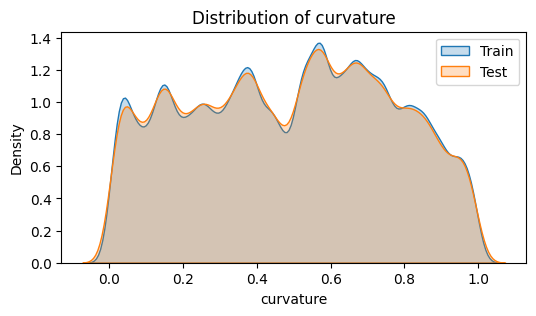

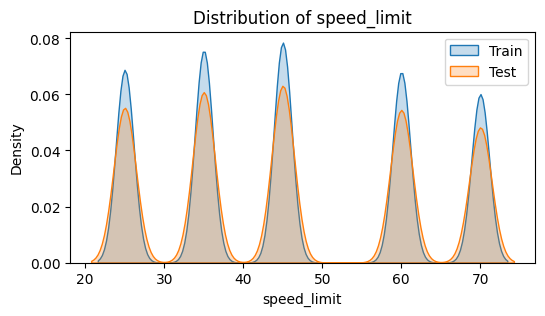

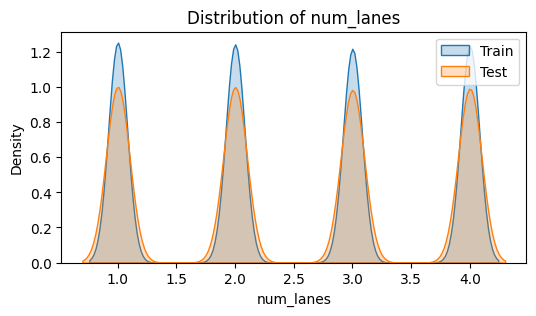

In [35]:
cols = ['curvature', 'speed_limit', 'num_lanes']  

for col in cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(train[col], label='Train', fill=True)
    sns.kdeplot(test[col], label='Test', fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

> both train data and test data are very similar

# Target variable analysis

> Here the target variable is accident_risk . To check target distribution ,plot histogram

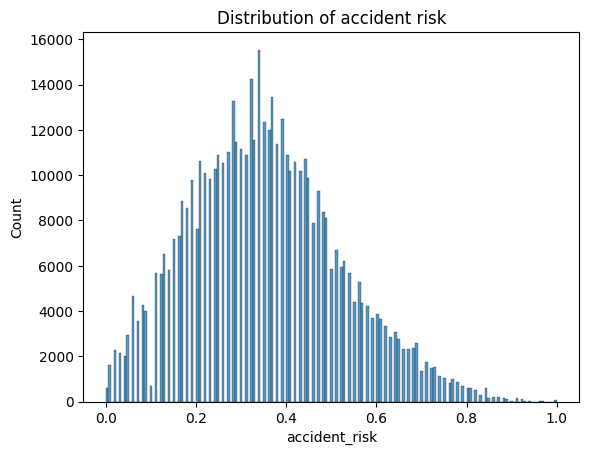

In [36]:
sns.histplot(x='accident_risk',data=train)
plt.title('Distribution of accident risk')
plt.show()

> The histplot is normal bell shaped structure and right skewed. It have long tail near 1.0 showing outliers.it can distroy the training  

In [37]:
train['accident_risk'].skew()

0.37841797634228086

> That means it is not heavily skewed.

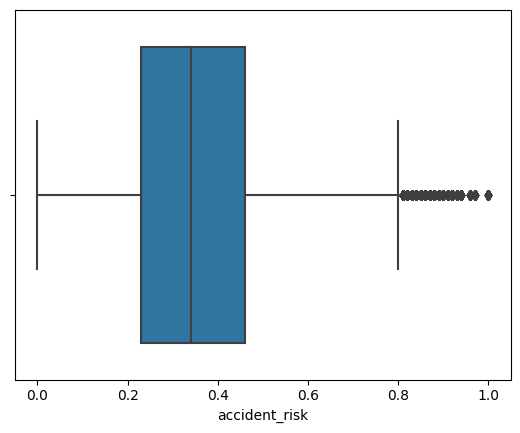

In [38]:
sns.boxplot(x='accident_risk',data=train)
plt.show()

> Here there is outliers but we didn't eliminate them because XGBRegressor can handle outliers 

# Data Preprocessing

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

> There are booliean columns which have true/false values and we want to convert into 1/0 using map function.

In [40]:
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in bool_cols:
    train[col] = train[col].map({True: 1, False: 0}) 
    test[col] = test[col].map({True: 1, False: 0}) 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  int64  
 8   public_road             517754 non-null  int64  
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  int64  
 11  school_season           517754 non-null  int64  
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: float64(2), int64

## categorical encodding

In [41]:
train.nunique()

id                        517754
road_type                      3
num_lanes                      4
curvature                    261
speed_limit                    5
lighting                       3
weather                        3
road_signs_present             2
public_road                    2
time_of_day                    3
holiday                        2
school_season                  2
num_reported_accidents         8
accident_risk                 98
dtype: int64

In [42]:
ohe=OneHotEncoder(drop=None, handle_unknown='ignore')
cat_cols=train.select_dtypes(include='object').columns.tolist()
encoded_data=ohe.fit_transform(train[cat_cols]).toarray()
encoded=pd.DataFrame(encoded_data,columns=ohe.get_feature_names_out(cat_cols))
train_numeric=train.drop(columns=cat_cols)
train=pd.concat([train_numeric.reset_index(drop=True),
                       encoded.reset_index(drop=True)],axis=1)

joblib.dump(ohe, "encoder.pkl")

['encoder.pkl']

In [43]:
ohe = joblib.load("encoder.pkl")

cat_cols_test = test.select_dtypes(include='object').columns.tolist()

# Transform test (no fitting here)
encoded_data_test = ohe.transform(test[cat_cols_test]).toarray()
encoded_test = pd.DataFrame(encoded_data_test, columns=ohe.get_feature_names_out(cat_cols_test))

test_numeric = test.drop(columns=cat_cols_test)
test = pd.concat([test_numeric.reset_index(drop=True),
                        encoded_test.reset_index(drop=True)], axis=1)

## Correlation between features

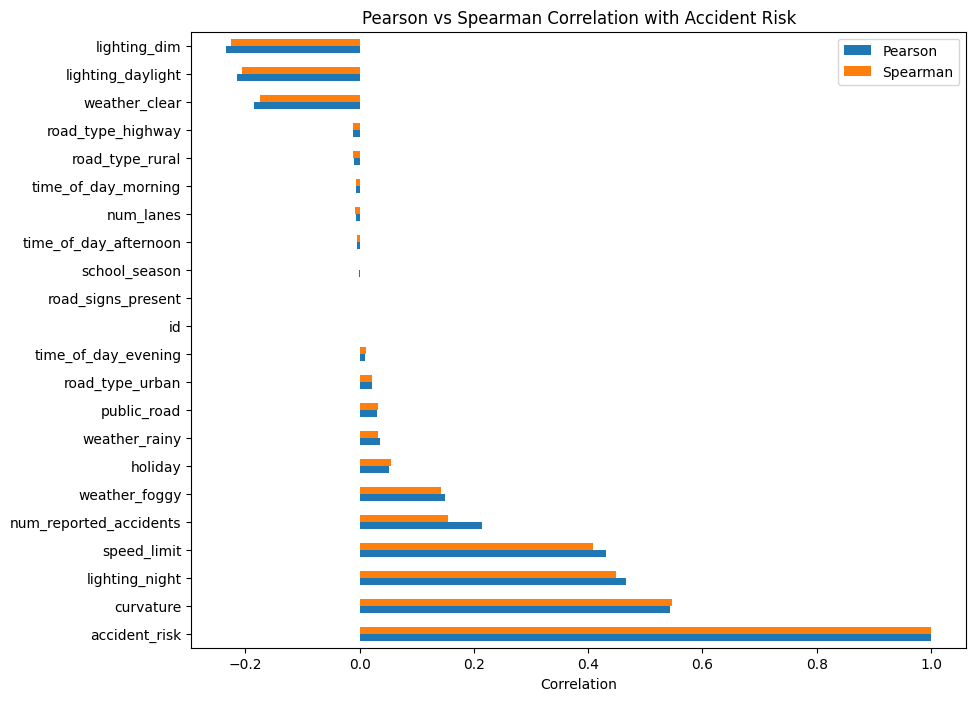

In [44]:
pearson = train.corr(method='pearson')['accident_risk']
spearman = train.corr(method='spearman')['accident_risk']

comparison = pd.DataFrame({'Pearson': pearson, 'Spearman': spearman}).sort_values('Pearson', ascending=False)

comparison.plot(kind='barh', figsize=(10,8))
plt.title('Pearson vs Spearman Correlation with Accident Risk')
plt.xlabel('Correlation')
plt.show()

> from this we understand some features have zero correlation and some other features have both linear and monotonic(increasing/decreasing) nature. But we didn't eliminate no features at this point because we don't know there is any nonlinear correlation

# Predictive Model

## Define Predictors and target values

In [45]:
X=train.drop(columns=['id','accident_risk'],axis=1)
y=train['accident_risk']

joblib.dump(X.columns.tolist(), "encoder_columns.pkl")

['encoder_columns.pkl']

In [46]:
scaler=StandardScaler()
X_cols=X.columns
X=scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)

## Split Data in train,test and validation set

In [47]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

## XGB Regressor

In [48]:
XGB = XGBRegressor(random_state=42, n_jobs=-1)
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.05606988543802257

## Hyperparameter tuning

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'tree_method': 'hist',  # faster on large datasets
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBRegressor(**params)

    # 5-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_root_mean_squared_error',
                             cv=kf, n_jobs=-1)
    
    return -scores.mean()

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Best RMSE: 0.056103088923462496

Best Hyperparameters:
n_estimators: 461
learning_rate: 0.18803922060548517
max_depth: 9
subsample: 0.7132825589513418
colsample_bytree: 0.9820106027924349
gamma: 0.018499753171678533
min_child_weight: 8
reg_alpha: 0.1556965924250059
reg_lambda: 0.31695815801791216

In [49]:
best_params = { 
    'n_estimators': 461,
    'learning_rate': 0.18803922060548517 ,
    'max_depth': 9 ,
    'subsample': 0.7132825589513418 ,
    'colsample_bytree': 0.9820106027924349 ,
    'gamma': 0.018499753171678533 ,
    'min_child_weight': 8 ,
    'reg_alpha': 0.1556965924250059 ,
    'reg_lambda': 0.31695815801791216
}
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"\nTest RMSE: {rmse:.4f}")


Test RMSE: 0.0560


# Submission

In [50]:
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9820106027924349, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.018499753171678533,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.18803922060548517,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=461, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
importances = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

lighting_night            0.646369
speed_limit               0.204676
weather_clear             0.077419
curvature                 0.042820
num_reported_accidents    0.016046
weather_rainy             0.004875
weather_foggy             0.004015
public_road               0.000571
holiday                   0.000527
num_lanes                 0.000297
lighting_daylight         0.000275
road_type_rural           0.000260
road_signs_present        0.000258
school_season             0.000247
time_of_day_afternoon     0.000244
time_of_day_morning       0.000234
road_type_urban           0.000233
time_of_day_evening       0.000230
road_type_highway         0.000203
lighting_dim              0.000201
dtype: float32


# Predict on Test Data 

In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   num_lanes               172585 non-null  int64  
 2   curvature               172585 non-null  float64
 3   speed_limit             172585 non-null  int64  
 4   road_signs_present      172585 non-null  int64  
 5   public_road             172585 non-null  int64  
 6   holiday                 172585 non-null  int64  
 7   school_season           172585 non-null  int64  
 8   num_reported_accidents  172585 non-null  int64  
 9   road_type_highway       172585 non-null  float64
 10  road_type_rural         172585 non-null  float64
 11  road_type_urban         172585 non-null  float64
 12  lighting_daylight       172585 non-null  float64
 13  lighting_dim            172585 non-null  float64
 14  lighting_night      

In [53]:
test_ids = test['id'].copy()

test_model = test.drop(columns=['id'], errors='ignore') 
test_model = pd.DataFrame(scaler.transform(test_model), columns=X_cols)
test_model = test_model.reindex(columns=X.columns, fill_value=0)
        
y_pred = final_model.predict(test_model)

submission = pd.DataFrame({
    'id': test_ids,
    'accident_risk': y_pred
})

submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!


In [54]:
joblib.dump(final_model, "model.pkl", compress=3)

['model.pkl']